OK, thus far we have been talking about linear models. All these can be viewed as a single-layer neural net. The next step is to move on to multi-layer nets. Training these is a bit more involved, and implementing from scratch requires time and effort. Instead, we just use well-established libraries. I prefer PyTorch, which is based on an earlier library called Torch (designed for training neural nets via backprop).

In [0]:
import numpy as np
import torch
import torchvision

Torch handles data types a bit differently. Everything in torch is a *tensor*.

In [0]:
a = np.random.rand(2,3)
print(a)

b = torch.from_numpy(a)
print(b)

[[0.97329184 0.8184028  0.53794621]
 [0.32927566 0.48143315 0.27906962]]
tensor([[0.9733, 0.8184, 0.5379],
        [0.3293, 0.4814, 0.2791]], dtype=torch.float64)


The idea in Torch is that tensors allow for easy forward (function evaluations) and backward (gradient) passes.

In [0]:
A = torch.rand(2,2)
b = torch.rand(2,1)
x = torch.rand(2,1, requires_grad=True)

y = torch.matmul(A,x) + b

print(y)
z = y.sum()
print(z)
z.backward()
print(x.grad)
print(x)

tensor([[0.9972],
        [0.7688]], grad_fn=<AddBackward0>)
tensor(1.7660, grad_fn=<SumBackward0>)
tensor([[0.8651],
        [1.3324]])
tensor([[0.0328],
        [0.7595]], requires_grad=True)


Notice how the backward pass computed the gradients using autograd. OK, enough background. Time to train some networks.

In [0]:
trainingdata = torchvision.datasets.FashionMNIST('./FashionMNIST/',train=True,download=True,transform=torchvision.transforms.ToTensor())
testdata = torchvision.datasets.FashionMNIST('./FashionMNIST/',train=False,download=True,transform=torchvision.transforms.ToTensor())


In [0]:
print(len(trainingdata),len(testdata))

60000 10000


OK, same size as MNIST. Let's display a few images.

In [0]:
image, label = trainingdata[0]
print(image.shape, label)

torch.Size([1, 28, 28]) 9


Hmm, it is a tensor, not an array. We need to postprocess to use matplotlib.

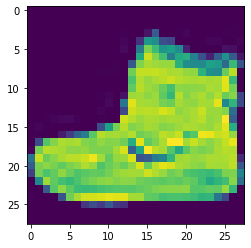

In [0]:
import matplotlib.pyplot as plt
%matplotlib inline
plt.imshow(image.squeeze().numpy())
plt.show()

Cool! Let's try plotting a few images. (Later).

In [0]:
trainDataLoader = torch.utils.data.DataLoader(trainingdata, batch_size=64, shuffle=True)
testDataLoader = torch.utils.data.DataLoader(testdata, batch_size=64, shuffle=False)

In [0]:
images, labels = iter(trainDataLoader).next()
print(images.size(), labels)

torch.Size([64, 1, 28, 28]) tensor([2, 7, 3, 6, 3, 7, 4, 9, 2, 6, 4, 9, 5, 2, 1, 4, 2, 5, 0, 4, 4, 4, 6, 2,
        5, 0, 4, 0, 5, 3, 9, 2, 3, 0, 6, 6, 8, 5, 9, 9, 4, 1, 2, 8, 5, 5, 6, 6,
        6, 7, 7, 4, 3, 3, 4, 0, 3, 8, 3, 8, 3, 4, 3, 3])


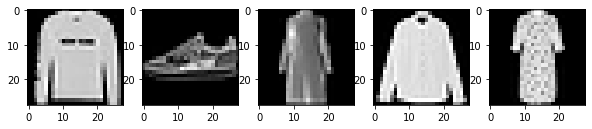

In [0]:
plt.figure(figsize=(10,4))
for index in np.arange(0,5):
  plt.subplot(1,5,index+1)
  plt.imshow(images[index].squeeze().numpy(),cmap=plt.cm.gray)

In [0]:
class LinearReg(torch.nn.Module):
  def __init__(self):
    super(LinearReg, self).__init__()
    self.linear = torch.nn.Linear(28*28,10)

  def forward(self, x):
    x = x.view(-1,28*28)
    transformed_x = self.linear(x)
    return transformed_x

net = LinearReg().cuda()
Loss = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(net.parameters(), lr=0.01)



Cool! Now we have set everything up. Let's try to train the network.

In [0]:
train_loss_history = []
test_loss_history = []

for epoch in range(20):
  train_loss = 0.0
  test_loss = 0.0
  for i, data in enumerate(trainDataLoader):
    images, labels = data
    images = images.cuda()
    labels = labels.cuda()
    optimizer.zero_grad()
    predicted_output = net(images)
    fit = Loss(predicted_output,labels)
    fit.backward()
    optimizer.step()
    train_loss += fit.item()
  for i, data in enumerate(testDataLoader):
    with torch.no_grad():
      images, labels = data
      images = images.cuda()
      labels = labels.cuda()
      predicted_output = net(images)
      fit = Loss(predicted_output,labels)
      test_loss += fit.item()
  train_loss = train_loss/len(trainDataLoader)
  test_loss = test_loss/len(testDataLoader)
  train_loss_history.append(train_loss)
  test_loss_history.append(test_loss)
  print('Epoch %s, Train loss %s, Test loss %s'%(epoch, train_loss, test_loss))

Epoch 0, Train loss 0.962718647044859, Test loss 0.7394164491231274
Epoch 1, Train loss 0.6678871326863385, Test loss 0.6467844312358054
Epoch 2, Train loss 0.6037305348209226, Test loss 0.6036576053519158
Epoch 3, Train loss 0.5682870054136969, Test loss 0.579158300996586
Epoch 4, Train loss 0.5456478984307632, Test loss 0.5595327822645758
Epoch 5, Train loss 0.5288768831346589, Test loss 0.5468165380939557
Epoch 6, Train loss 0.5162919589769103, Test loss 0.5357637635082196
Epoch 7, Train loss 0.5059161315213389, Test loss 0.52770537024091
Epoch 8, Train loss 0.4975833669781431, Test loss 0.5209156887926114
Epoch 9, Train loss 0.490400868263453, Test loss 0.515774294828913
Epoch 10, Train loss 0.4842610348230486, Test loss 0.5096913139531567
Epoch 11, Train loss 0.4788224052455125, Test loss 0.506357757528876
Epoch 12, Train loss 0.47393937836260175, Test loss 0.5024205670235263
Epoch 13, Train loss 0.4699769388796932, Test loss 0.5000300154944134
Epoch 14, Train loss 0.4662028041316

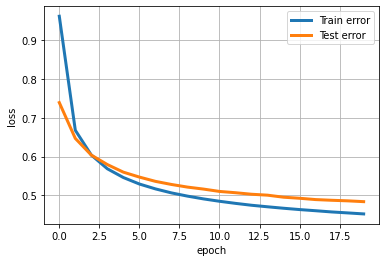

In [0]:
plt.plot(range(20),train_loss_history,'-',linewidth=3,label='Train error')
plt.plot(range(20),test_loss_history,'-',linewidth=3,label='Test error')
plt.xlabel('epoch')
plt.ylabel('loss')
plt.grid(True)
plt.legend()

Evaluate on the entire dataset!

In [0]:
predicted_output = net(images)
print(torch.max(predicted_output, 1))
fit = Loss(predicted_output, labels)
print(labels)

torch.return_types.max(
values=tensor([ 6.0837,  3.1317,  9.1140,  7.7421,  6.6457,  6.1580, 10.1397,  4.2204,
         6.8977, 11.5810, 10.6048, 10.2698,  6.7915,  4.7407,  9.4972,  4.4949],
       device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor([3, 1, 7, 5, 8, 2, 5, 6, 8, 9, 1, 9, 1, 8, 1, 5], device='cuda:0'))
tensor([3, 2, 7, 5, 8, 4, 5, 6, 8, 9, 1, 9, 1, 8, 1, 5], device='cuda:0')
